<h1 align="center">MSIN0114: Business Analytics Consulting Project</h1>
<h2 align="center">S2R Analytics</h2>

# Table of Contents

**Predictive analytics (ML pipeline)**

* [Part 3](#part3): Preprocessing
    * [3.1](#3_1): Missing values
    * [3.2](#3_2): Outliers
    * [3.3](#3_3): Conversion
    * [3.4](#3_4): Scaling
    * [3.5](#3_5): Feature engineering
    * [3.6](#3_6): Encoding
    * [3.7](#3_7): Splitting
<br />
<br />
* [Part 4](#part4): Exploratory data analysis
* [Part 5](#part5): Model training
* [Part 6](#part6): Performance evaluation
* [Part 7](#part7): Feature importance and statistical tests
* [Part 8](#part8): Converting the output
* [Part 9](#part9): Pipeline creation

## Notebook Setup

In [1]:
#Essentials
import pandas as pd
from pandas import Series, DataFrame
from pandas.api.types import CategoricalDtype
pd.options.display.max_columns = None
import sqlite3
import pyodbc

#Image creation and display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib import pyplot
import plotly.express as px
import plotly.graph_objects as go
#from image import image, display

#Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier

#Other
import itertools as it
import io
import os
os.sys.path
import sys
import glob
import concurrent.futures
from __future__ import print_function
import binascii
import struct
from PIL import Image
import scipy
import scipy.misc
import scipy.cluster
import datetime, time
import functools, operator
from datetime import datetime
from numpy.random import seed
from numpy.random import randn
from numpy import percentile

In [4]:
df = pd.read_csv('project_lvl.csv')
df.head()

,Project_ID,Country,Office,Sector,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project,Default_Rate_Group,Perc_of_Stages_with_Fixed_Fee,Manager_Is_Recent,Project_Director,Perc_of_Subcontractors,Project_Duration_Weeks,Is_Front_Loaded,Delivered_on_Time,Fully_In_Lockdown,Partially_In_Lockdown,Suffered_Data_Loss,Total_Data_Issues,Avg_Rec,Avg_Profit,Staff_ID,Synergy_Team,Employment_Total_Months
0,367704,Australia,Whyalla,Ports & Marine,4.0,False,True,Standard,100.0,False,Mark Gilbert,0.0,4.0,True,NaN,False,False,False,2.0,2.070711,0.991479,7612852.0,SA - Industrial,117.0
1,367705,Australia,WGASA Pty Ltd,Civic & Education Buildings,1.0,False,True,Standard,NaN,NaN,Geoff Wallbridge,0.0,NaN,False,NaN,False,False,NaN,2.0,1.926671,0.000000,7612773.0,SA - Buildings,310.0
2,367706,Australia,WGASA Pty Ltd,Civic & Education Buildings,1.0,False,True,Standard,NaN,NaN,Loreto Taglienti,0.0,NaN,False,NaN,False,False,NaN,0.0,1.936449,1.290966,7612773.0,SA - Buildings,310.0
3,367707,Australia,WGASA Pty Ltd,Commercial & Retail Buildings,3.0,False,True,Standard,NaN,NaN,Mark Gilbert,0.0,NaN,False,NaN,False,False,NaN,1.0,2.053392,1.631426,7612773.0,SA - Buildings,310.0
4,367708,Australia,WGASA Pty Ltd,Civic & Education Buildings,7.0,False,True,Standard,NaN,NaN,Peter McBean,0.0,NaN,False,NaN,False,False,NaN,3.0,1.082860,0.000000,7612695.0,SA - Buildings,420.0


In [14]:
df1 = pd.read_csv('stage_lvl.csv')
df1.head()

c:\Users\MarfaPopova\S2R Analytics\Development & Support Team - Power BI for Synergy - Advanced Analytics\DataFlowExtract\venv\lib\site-packages\IPython\core\interactiveshell.py:3398: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Project_ID,Country,Office,Sector,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project,Default_Rate_Group,Perc_of_Stages_with_Fixed_Fee,Manager_Is_Recent,Project_Director,Perc_of_Subcontractors,Project_Duration_Weeks,Is_Front_Loaded,Delivered_on_Time,Fully_In_Lockdown,Partially_In_Lockdown,Suffered_Data_Loss,Total_Data_Issues,Avg_Rec,Avg_Profit,Project_Manager,Synergy_Team,Employment_Total_Months,Client_ID,Client_Projects_Total_No,Client_Is_Repeated,Client_Duration_Months,Client_Is_Recent,Stage_ID,Total_Num_Stages,Is_Disbursement_Stage,Stage_Discipline,Stage_Duration_Weeks,Stage_Fee_Type
0,367704,Australia,Whyalla,Ports & Marine,4.0,False,True,Standard,100.0,False,Mark Gilbert,0.0,4.0,True,NaN,False,False,False,2.0,2.070711,0.991479,7612852.0,SA - Industrial,117.0,7615441.0,6.0,True,146.0,False,1388262.0,1.0,No,Design,0.0,Fixed fee
1,367705,Australia,WGASA Pty Ltd,Civic & Education Buildings,1.0,False,True,Standard,NaN,NaN,Geoff Wallbridge,0.0,NaN,False,NaN,False,False,NaN,2.0,1.926671,0.000000,7612773.0,SA - Buildings,310.0,7615975.0,1.0,True,138.0,False,NaN,NaN,NaN,NaN,NaN,NaN
2,367706,Australia,WGASA Pty Ltd,Civic & Education Buildings,1.0,False,True,Standard,NaN,NaN,Loreto Taglienti,0.0,NaN,False,NaN,False,False,NaN,0.0,1.936449,1.290966,7612773.0,SA - Buildings,310.0,7614333.0,3.0,True,149.0,False,NaN,NaN,NaN,NaN,NaN,NaN
3,367707,Australia,WGASA Pty Ltd,Commercial & Retail Buildings,3.0,False,True,Standard,NaN,NaN,Mark Gilbert,0.0,NaN,False,NaN,False,False,NaN,1.0,2.053392,1.631426,7612773.0,SA - Buildings,310.0,7614635.0,1.0,True,149.0,False,NaN,NaN,NaN,NaN,NaN,NaN
4,367708,Australia,WGASA Pty Ltd,Civic & Education Buildings,7.0,False,True,Standard,NaN,NaN,Peter McBean,0.0,NaN,False,NaN,False,False,NaN,3.0,1.082860,0.000000,7612695.0,SA - Buildings,420.0,7613925.0,13.0,True,149.0,False,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
len(df1)

26377

In [15]:
df1['Project_ID'].value_counts()

372801     133
564956      91
891288      89
674119      89
368133      86
          ... 
372069       1
372070       1
372071       1
372073       1
1567895      1
Name: Project_ID, Length: 9755, dtype: int64

## Part 3: <a class="anchor" id="part3"></a> Preprocessing

### 3.1 <a class="anchor" id="3_1"></a> Missing values

In [5]:
# Number of columns having null values in the dataset
cols = df.columns[df.isnull().any()].to_list()

for c in cols:
    print(c, df[c].isnull().sum())

Country 115
Project_Size_Sort_Order 1
Is_Multi_Discipline_Project 1
Is_First_Client_Project 1
Perc_of_Stages_with_Fixed_Fee 6524
Manager_Is_Recent 5789
Project_Director 1
Perc_of_Subcontractors 595
Project_Duration_Weeks 5746
Is_Front_Loaded 275
Delivered_on_Time 7778
Suffered_Data_Loss 5719
Total_Data_Issues 3
Avg_Rec 627
Avg_Profit 627
Staff_ID 435
Synergy_Team 435
Employment_Total_Months 435


In [6]:
# URL: https://datascience.stackexchange.com/questions/12645/how-to-count-the-number-of-missing-values-in-each-row-in-pandas-dataframe
df['non_missing_count'] = df.apply(lambda x: x.count(), axis=1)
df['non_missing_count'].value_counts()

19    4814
23    1904
24    1324
16     608
22     513
20     338
15     117
21      44
17      41
18      31
13      15
12       4
14       2
Name: non_missing_count, dtype: int64

Rows with more than 7 empty columns will be dropped, so the minimum number of non-missing columns per row should be 17.

In [7]:
print('Minimum values each coumn should have is set to e at least half of the dataset, i.e. '+ str(round(len(df)/2))+' rows.')

Minimum values each coumn should have is set to e at least half of the dataset, i.e. 4878 rows.


In [8]:
df = df[(df['non_missing_count']) >= 17]
df

,Project_ID,Country,Office,Sector,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project,Default_Rate_Group,Perc_of_Stages_with_Fixed_Fee,Manager_Is_Recent,Project_Director,Perc_of_Subcontractors,Project_Duration_Weeks,Is_Front_Loaded,Delivered_on_Time,Fully_In_Lockdown,Partially_In_Lockdown,Suffered_Data_Loss,Total_Data_Issues,Avg_Rec,Avg_Profit,Staff_ID,Synergy_Team,Employment_Total_Months,non_missing_count
0,367704,Australia,Whyalla,Ports & Marine,4.0,False,True,Standard,100.00,False,Mark Gilbert,0.0,4.0,True,NaN,False,False,False,2.0,2.070711,0.991479,7612852.0,SA - Industrial,117.0,23
1,367705,Australia,WGASA Pty Ltd,Civic & Education Buildings,1.0,False,True,Standard,NaN,NaN,Geoff Wallbridge,0.0,NaN,False,NaN,False,False,NaN,2.0,1.926671,0.000000,7612773.0,SA - Buildings,310.0,19
2,367706,Australia,WGASA Pty Ltd,Civic & Education Buildings,1.0,False,True,Standard,NaN,NaN,Loreto Taglienti,0.0,NaN,False,NaN,False,False,NaN,0.0,1.936449,1.290966,7612773.0,SA - Buildings,310.0,19
3,367707,Australia,WGASA Pty Ltd,Commercial & Retail Buildings,3.0,False,True,Standard,NaN,NaN,Mark Gilbert,0.0,NaN,False,NaN,False,False,NaN,1.0,2.053392,1.631426,7612773.0,SA - Buildings,310.0,19
4,367708,Australia,WGASA Pty Ltd,Civic & Education Buildings,7.0,False,True,Standard,NaN,NaN,Peter McBean,0.0,NaN,False,NaN,False,False,NaN,3.0,1.082860,0.000000,7612695.0,SA - Buildings,420.0,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9749,1523716,Australia,WGASA Pty Ltd,Traffic Transport (Bridges),3.0,False,False,SA June 2021 Chargeout Rates,100.00,False,Alex Lloyd,NaN,18.0,NaN,NaN,False,False,False,1.0,NaN,NaN,7612752.0,SA - Civil,176.0,19
9750,1524776,Australia,WGAVIC Pty Ltd,Civic & Education Buildings,1.0,False,False,Vic chargeout FY22,66.67,False,James Brownlie,NaN,1.0,NaN,True,False,False,False,1.0,NaN,NaN,9501752.0,VIC - Traffic,10.0,20
9751,1529864,Australia,WGAWA Pty Ltd,Civic & Education Buildings,1.0,False,False,WA Chargeout Rates from 1st July 2021,50.00,False,James Davidson,NaN,1.0,NaN,NaN,False,False,False,1.0,NaN,NaN,7809410.0,WA - Civil,20.0,19
9752,1538446,Australia,WGAVIC Pty Ltd,Energy,1.0,False,False,Vic chargeout FY22,100.00,False,Cameron Jackson (MPD),NaN,3.0,NaN,True,False,False,False,0.0,NaN,NaN,7612860.0,VIC - Buildings,172.0,20


In [9]:
# Drop ID columns and those with too many missing values
df.drop(columns = ['Staff_ID', 'Perc_of_Stages_with_Fixed_Fee', 'Project_Duration_Weeks', 'Delivered_on_Time', 'Suffered_Data_Loss'], inplace = True)

# Replacing null values with the most frequent strings and booleans
df['Country'].fillna(df['Country'].value_counts().idxmax(), inplace = True)
df['Project_Director'].fillna(df['Project_Director'].value_counts().idxmax(), inplace = True)
df['Is_First_Client_Project'].fillna(df['Is_First_Client_Project'].value_counts().idxmax(), inplace = True)
df['Manager_Is_Recent'].fillna(df['Manager_Is_Recent'].value_counts().idxmax(), inplace = True)
df['Is_Front_Loaded'].fillna(df['Is_Front_Loaded'].value_counts().idxmax(), inplace = True)
df['Synergy_Team'].fillna(df['Synergy_Team'].value_counts().idxmax(), inplace = True)

Whether to perform imputatipon of missed vakues with median or mean, always depends on your data and your task.
If there is a dataset that have great outliers, I'll prefer median. E.x.: 99% of household income is below 100, and 1% is above 500.

First, let's deal with small amoun of nulls. Check: df.boxplot('Perc_of_Stages_with_Fixed_Fee')

In [10]:
# Using median to impute the missing values
missing_size = ['Project_Size_Sort_Order']
for s in missing_size:
    df.loc[df.loc[:,s].isnull(),s]=df.loc[:,s].median()

missing_rec = ['Avg_Rec']
for r in missing_rec:
    df.loc[df.loc[:,r].isnull(),r]=df.loc[:,r].median()
    
missing_profit = ['Avg_Profit']
for p in missing_profit:
    df.loc[df.loc[:,p].isnull(),p]=int(df.loc[:,p].median())

missing_subcontractors = ['Perc_of_Subcontractors']
for s in missing_subcontractors:
    df.loc[df.loc[:,s].isnull(),s]=int(df.loc[:,s].median())

missing_months = ['Employment_Total_Months']
for m in missing_months:
    df.loc[df.loc[:,m].isnull(),m]=int(df.loc[:,m].median())

missing_months = ['Employment_Total_Months']
for m in missing_months:
    df.loc[df.loc[:,m].isnull(),m]=int(df.loc[:,m].median())

In [11]:
# Verify the changes
df.isnull().sum()

Project_ID                     0
Country                        0
Office                         0
Sector                         0
Project_Size_Sort_Order        0
Is_Multi_Discipline_Project    0
Is_First_Client_Project        0
Default_Rate_Group             0
Manager_Is_Recent              0
Project_Director               0
Perc_of_Subcontractors         0
Is_Front_Loaded                0
Fully_In_Lockdown              0
Partially_In_Lockdown          0
Total_Data_Issues              0
Avg_Rec                        0
Avg_Profit                     0
Synergy_Team                   0
Employment_Total_Months        0
non_missing_count              0
dtype: int64

In [13]:
df.drop(columns = 'non_missing_count', inplace = True)
df.head()

,Project_ID,Country,Office,Sector,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project,Default_Rate_Group,Manager_Is_Recent,Project_Director,Perc_of_Subcontractors,Is_Front_Loaded,Fully_In_Lockdown,Partially_In_Lockdown,Total_Data_Issues,Avg_Rec,Avg_Profit,Synergy_Team,Employment_Total_Months
0,367704,Australia,Whyalla,Ports & Marine,4.0,False,True,Standard,False,Mark Gilbert,0.0,True,False,False,2.0,2.070711,0.991479,SA - Industrial,117.0
1,367705,Australia,WGASA Pty Ltd,Civic & Education Buildings,1.0,False,True,Standard,False,Geoff Wallbridge,0.0,False,False,False,2.0,1.926671,0.000000,SA - Buildings,310.0
2,367706,Australia,WGASA Pty Ltd,Civic & Education Buildings,1.0,False,True,Standard,False,Loreto Taglienti,0.0,False,False,False,0.0,1.936449,1.290966,SA - Buildings,310.0
3,367707,Australia,WGASA Pty Ltd,Commercial & Retail Buildings,3.0,False,True,Standard,False,Mark Gilbert,0.0,False,False,False,1.0,2.053392,1.631426,SA - Buildings,310.0
4,367708,Australia,WGASA Pty Ltd,Civic & Education Buildings,7.0,False,True,Standard,False,Peter McBean,0.0,False,False,False,3.0,1.082860,0.000000,SA - Buildings,420.0


### 3.2 <a class="anchor" id="3_2"></a> Outliers

In [65]:
# URL: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

# seed the random number generator
seed(1)

# calculate interquartile range
q25, q75 = percentile(df['Avg_Rec'], 25), percentile(df['Avg_Rec'], 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [x for x in df['Avg_Rec'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in df['Avg_Rec'] if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Percentiles: 25th=1.492, 75th=1.811, IQR=0.320
Identified outliers: 218
Non-outlier observations: 8791


In [66]:
# seed the random number generator
seed(1)

# calculate interquartile range
q25, q75 = percentile(df['Avg_Profit'], 25), percentile(df['Avg_Profit'], 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [x for x in df['Avg_Profit'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers
outliers_removed = [x for x in df['Avg_Profit'] if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Percentiles: 25th=1.093, 75th=1.996, IQR=0.903
Identified outliers: 562
Non-outlier observations: 8447


### 3.3 <a class="anchor" id="3_3"></a> Conversion

In [67]:
# Convert the object column to boolean
df['Is_Multi_Discipline_Project'] = df['Is_Multi_Discipline_Project'].astype(bool)
df['Is_Multi_Discipline_Project'] = df['Is_Multi_Discipline_Project'].astype(int)
df['Is_First_Client_Project'] = df['Is_First_Client_Project'].astype(int)
df['Manager_Is_Recent'] = df['Manager_Is_Recent'].astype(int)
df['Is_Front_Loaded'] = df['Is_Front_Loaded'].astype(int)

In [68]:
df['Fully_In_Lockdown'].value_counts()

False    9009
Name: Fully_In_Lockdown, dtype: int64

In [69]:
df['Partially_In_Lockdown'].value_counts()

False    9009
Name: Partially_In_Lockdown, dtype: int64

In [70]:
df.drop(columns = ['Fully_In_Lockdown', 'Partially_In_Lockdown'], inplace = True)

In [71]:
df.head()

,Project_ID,Country,Office,Sector,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project,Default_Rate_Group,Manager_Is_Recent,Project_Director,Perc_of_Subcontractors,Is_Front_Loaded,Total_Data_Issues,Avg_Rec,Avg_Profit,Synergy_Team,Employment_Total_Months,non_missing_count
0,367704,Australia,Whyalla,Ports & Marine,4.0,0,1,Standard,0,Mark Gilbert,0.0,1,2.0,2.070711,0.991479,SA - Industrial,117.0,23
1,367705,Australia,WGASA Pty Ltd,Civic & Education Buildings,1.0,0,1,Standard,0,Geoff Wallbridge,0.0,0,2.0,1.926671,0.000000,SA - Buildings,310.0,19
2,367706,Australia,WGASA Pty Ltd,Civic & Education Buildings,1.0,0,1,Standard,0,Loreto Taglienti,0.0,0,0.0,1.936449,1.290966,SA - Buildings,310.0,19
3,367707,Australia,WGASA Pty Ltd,Commercial & Retail Buildings,3.0,0,1,Standard,0,Mark Gilbert,0.0,0,1.0,2.053392,1.631426,SA - Buildings,310.0,19
4,367708,Australia,WGASA Pty Ltd,Civic & Education Buildings,7.0,0,1,Standard,0,Peter McBean,0.0,0,3.0,1.082860,0.000000,SA - Buildings,420.0,19


### 3.4 <a class="anchor" id="3_3"></a> Scaling

“To ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features, we scale the data before feeding it to the model.” (Analytics Vidhya, 2020) In our case, normalisation works better than standardisation, as outliers have been handled, and data does not seem to follow a normal distribution.

In [79]:
# Select the numerical columns only
floats = df.copy()
floats = floats.select_dtypes(include=['float64'])

# Scale the numerical columns
d = preprocessing.normalize(floats)
floats = pd.DataFrame(d, columns = floats.columns)
floats

,Project_Size_Sort_Order,Perc_of_Subcontractors,Total_Data_Issues,Avg_Rec,Avg_Profit,Employment_Total_Months
0,0.034157,0.0,0.017078,0.017682,0.008466,0.999078
1,0.003226,0.0,0.006451,0.006215,0.000000,0.999955
2,0.003226,0.0,0.000000,0.006246,0.004164,0.999967
3,0.009677,0.0,0.003226,0.006623,0.005262,0.999912
4,0.016664,0.0,0.007142,0.002578,0.000000,0.999832
...,...,...,...,...,...,...
9004,0.017042,0.0,0.005681,0.009354,0.005681,0.999779
9005,0.097261,0.0,0.097261,0.160161,0.097261,0.972610
9006,0.049647,0.0,0.049647,0.081754,0.049647,0.992936
9007,0.005813,0.0,0.000000,0.009573,0.005813,0.999920


In [85]:
bools = df.copy()
bools = bools.select_dtypes(include=['int32']).reset_index(col_level=0, drop=True)
bools

,Is_Multi_Discipline_Project,Is_First_Client_Project,Manager_Is_Recent,Is_Front_Loaded
0,0,1,0,1
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
9004,0,0,0,0
9005,0,0,0,0
9006,0,0,0,0
9007,0,0,0,0


In [86]:
num = pd.concat([floats, bools], axis=1) # concatenating dataframes horizontally
num

,Project_Size_Sort_Order,Perc_of_Subcontractors,Total_Data_Issues,Avg_Rec,Avg_Profit,Employment_Total_Months,Is_Multi_Discipline_Project,Is_First_Client_Project,Manager_Is_Recent,Is_Front_Loaded
0,0.034157,0.0,0.017078,0.017682,0.008466,0.999078,0,1,0,1
1,0.003226,0.0,0.006451,0.006215,0.000000,0.999955,0,1,0,0
2,0.003226,0.0,0.000000,0.006246,0.004164,0.999967,0,1,0,0
3,0.009677,0.0,0.003226,0.006623,0.005262,0.999912,0,1,0,0
4,0.016664,0.0,0.007142,0.002578,0.000000,0.999832,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
9004,0.017042,0.0,0.005681,0.009354,0.005681,0.999779,0,0,0,0
9005,0.097261,0.0,0.097261,0.160161,0.097261,0.972610,0,0,0,0
9006,0.049647,0.0,0.049647,0.081754,0.049647,0.992936,0,0,0,0
9007,0.005813,0.0,0.000000,0.009573,0.005813,0.999920,0,0,0,0


In [88]:
df['Perc_of_Subcontractors'].value_counts()

0.00     8730
0.06       11
0.12        9
0.40        6
0.07        5
         ... 
1.05        1
11.54       1
1.97        1
1.14        1
2.22        1
Name: Perc_of_Subcontractors, Length: 142, dtype: int64

<AxesSubplot:title={'center':'Scatter plot between two variables X and Y'}, xlabel='Avg_Rec', ylabel='Avg_Profit'>

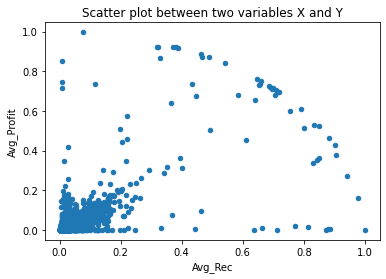

In [18]:
num.plot.scatter(x='Avg_Rec', y='Avg_Profit', title= "Scatter plot between two variables X and Y")

### 3.5 <a class="anchor" id="3_5"></a> Feature engineering

In [139]:
all_bins = pd.DataFrame(num, columns = ['Avg_Rec', 'Avg_Profit'])
all_bins

,Avg_Rec,Avg_Profit
0,0.017682,0.008466
1,0.006215,0.000000
2,0.006246,0.004164
3,0.006623,0.005262
4,0.002578,0.000000
...,...,...
9004,0.009354,0.005681
9005,0.160161,0.097261
9006,0.081754,0.049647
9007,0.009573,0.005813


c:\Users\MarfaPopova\S2R Analytics\Development & Support Team - Power BI for Synergy - Advanced Analytics\DataFlowExtract\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


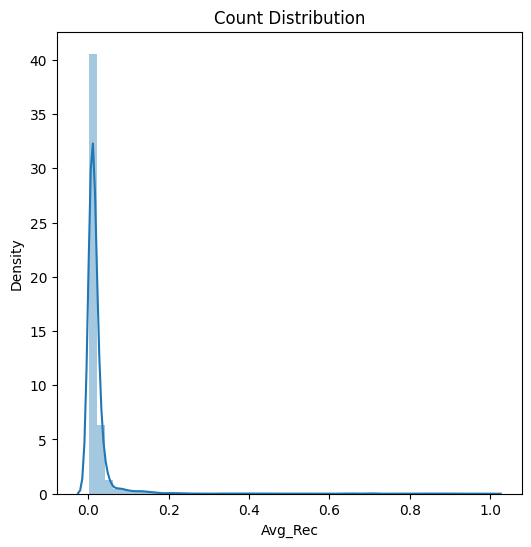

In [143]:
#Distribution of count of all points, with outliers
plt.figure(figsize=(6,6))
sns.distplot(num['Avg_Rec'])
plt.title('Count Distribution')
plt.show()

In [172]:
num['Avg_Rec'].value_counts().describe()

count    8804.000000
mean        1.023285
std         0.250463
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         9.000000
Name: Avg_Rec, dtype: float64

In [144]:
num['Avg_Rec'].median()

0.010753288485757217

In [173]:
# calculate the minimum and maximum bounds aside outliers
q25, q75 = percentile(num['Avg_Rec'], 25), percentile(num['Avg_Rec'], 75)
iqr = q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
print(lower, upper)

-0.009400927443332057 0.0359284177339583


In [179]:
q75

0.01892991329247442

<AxesSubplot:>

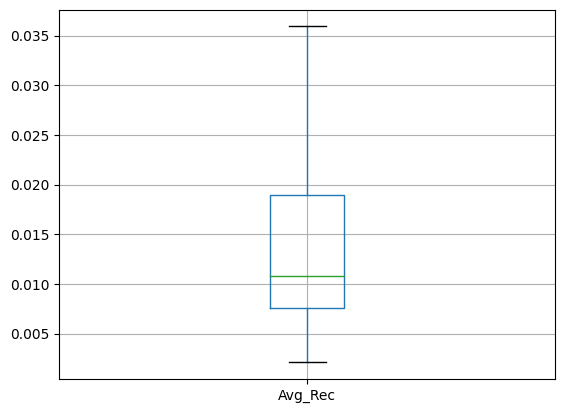

In [147]:
num.boxplot('Avg_Rec', showfliers=False) # boxplot without outliers, the green line corresponds to the abovemntionned median of 0.010753288485757217

Interpretation: https://www.mathbootcamps.com/how-to-read-a-boxplot/

<AxesSubplot:>

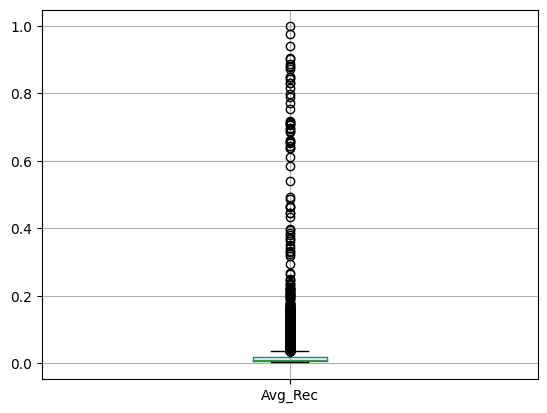

In [180]:
num.boxplot('Avg_Rec')

Now we can create 3 recoverability classes based on the median recoverability as our threshold.

In [168]:
project_ids = df[['Project_ID']]
project_ids.reset_index(drop=True, inplace = True)
num = pd.concat([project_ids, num], axis=1) # concatenating dataframes horizontally
len(num)

9009

In [181]:
rec_class = {}

for rec in num['Avg_Rec']:
  for project_id in num['Project_ID']:
    if rec < 0.0075975769981518285:
      rec_class[project_id] = 0 # unprofitable projects are lower than median
    elif rec > 0.01892991329247442:
      rec_class[project_id]  = 2 # very profitable projects are higher than upper bond
    else:
      rec_class[project_id]  = 1 # average profitable projects are those between the median and upper bound

In [182]:
rec_df = pd.DataFrame([{'Project_ID': project_id, 'Rec_Class': rec_class} for (project_id, rec_class) in rec_class.items()])
rec_df.head()

,Project_ID,Rec_Class
0,367704,1
1,367705,1
2,367706,1
3,367707,1
4,367708,1


In [183]:
rec_df['Rec_Class'].value_counts()

1    9009
Name: Rec_Class, dtype: int64

In [170]:
df['Avg_Profit'].min(), df['Avg_Profit'].median(), df['Avg_Profit'].max()

(0.0, 1.51034200286709, 16389.220348073926)

<AxesSubplot:>

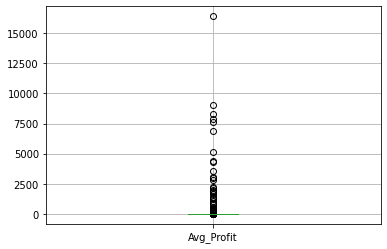

In [171]:
df.boxplot('Avg_Profit')

Now we can create 3 profit measure classes based on the median profit measurement as our threshold.

In [175]:
profit_class = {}

for profit in df['Avg_Profit']:
  for project_id in df['Project_ID']:
    if profit <= 1.51:
      profit_class[project_id] = 0 # unprofitable
    elif profit >= 2500:
      profit_class[project_id]  = 2 # extremely profitable
    else:
      profit_class[project_id]  = 1 # average profitable

In [176]:
profit_df = pd.DataFrame([{'Project_ID': project_id, 'Profit_Class': profit_class} for (project_id, profit_class) in profit_class.items()])
profit_df.head()

,Project_ID,Profit_Class
0,367704,0
1,367705,0
2,367706,0
3,367707,0
4,367708,0


In [179]:
profitability_df = pd.merge(rec_df, profit_df, how='left', left_on='Project_ID', right_on='Project_ID')
profitability_df['Profitability_Class'] = profitability_df['Rec_Class'] + profitability_df['Profit_Class']
profitability_df 

,Project_ID,Rec_Class,Profit_Class,Profitability_Class
0,367704,0,0,0
1,367705,0,0,0
2,367706,0,0,0
3,367707,0,0,0
4,367708,0,0,0
...,...,...,...,...
9004,1523716,0,0,0
9005,1524776,0,0,0
9006,1529864,0,0,0
9007,1538446,0,0,0


In [183]:
profitability_df['Profitability_Class'].value_counts()

0    9009
Name: Profitability_Class, dtype: int64

In [181]:
prep_classes = profitability_df['Profitability_Class'].sum()
#prep_classes.rename(columns={0:'NFT_count'},inplace=True)
#prep_classes.rename(columns={'index': 'category'}, inplace=True)
prep_classes

0

### 3.6 <a class="anchor" id="3_6"></a> Encoding

In [ ]:
# select the float columns
categorical = df.copy()
test = categorical.select_dtypes(include=['object'])

In [ ]:
le = LabelEncoder()
categorical['creator'] = le.fit_transform(categorical['creator'])
categorical.head()

### 3.7 <a class="anchor" id="3_7"></a> Splitting

In [ ]:
# Split dataset into features and labels
X = df[['creator', 'artwork_name', 'collection',
           'art_series', 'media', 'likes', 'nsfw',
           'tokens','year', 'rights', 'artwork_counts']]  # Removed original price
y = df['price_class']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022) # 80% training and 20% test
print(f"No. of training data: {X_train.shape[0]}")
print(f"No. of training targets: {y_train.shape[0]}")
print(f"No. of testing data: {X_test.shape[0]}")
print(f"No. of testing targets: {y_test.shape[0]}")

## Part 4: <a class="anchor" id="part4"></a> Exploratory data analysis

In [ ]:
# Correlation matrix

CorrVars = encoded_df.columns
correlation_df = encoded_df[CorrVars].corr().apply(lambda x:round(x,3))

ax = sns.heatmap(correlation_df,annot=False, vmin=-1, vmax=1, center=0)
ax.set_title("Correlation Matrix", fontsize = 14)

_ = ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    horizontalalignment='right')

plt.savefig('correlation_matrix.png')